In [8]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Data_Dir = "../input/cats-faces-64x64-for-generative-models"

In [3]:
print(os.listdir(Data_Dir))

['cats']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(Data_Dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

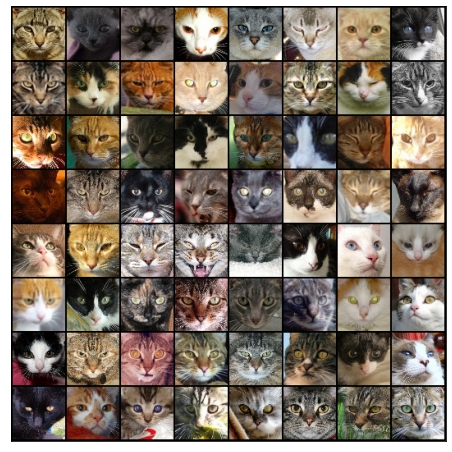

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


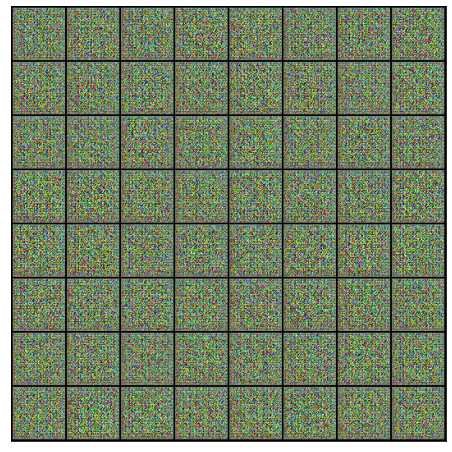

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


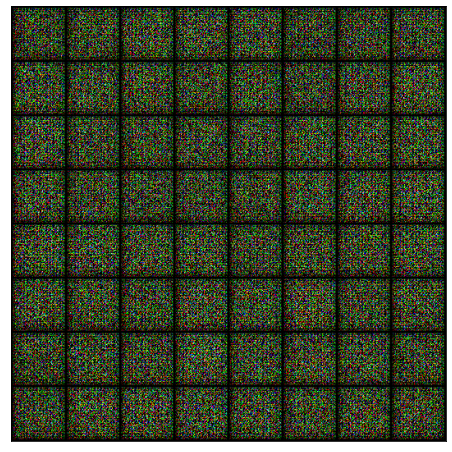

In [25]:
save_samples(0, fixed_latent)

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 60

In [28]:
history = fit(epochs, lr)


Epoch [1/60], loss_g: 4.4783, loss_d: 1.5544, real_score: 0.3165, fake_score: 0.0118
Saving generated-images-0001.png



Epoch [2/60], loss_g: 1.8770, loss_d: 0.8745, real_score: 0.6289, fake_score: 0.1873
Saving generated-images-0002.png



Epoch [3/60], loss_g: 4.5170, loss_d: 0.7795, real_score: 0.9573, fake_score: 0.4680
Saving generated-images-0003.png



Epoch [4/60], loss_g: 2.9154, loss_d: 0.9722, real_score: 0.4301, fake_score: 0.0384
Saving generated-images-0004.png



Epoch [5/60], loss_g: 3.9109, loss_d: 0.6341, real_score: 0.6425, fake_score: 0.0688
Saving generated-images-0005.png



Epoch [6/60], loss_g: 4.5760, loss_d: 0.4413, real_score: 0.9973, fake_score: 0.3169
Saving generated-images-0006.png



Epoch [7/60], loss_g: 5.0917, loss_d: 0.2413, real_score: 0.8781, fake_score: 0.0971
Saving generated-images-0007.png



Epoch [8/60], loss_g: 4.4169, loss_d: 0.1435, real_score: 0.9771, fake_score: 0.0986
Saving generated-images-0008.png



Epoch [9/60], loss_g: 5.1868, loss_d: 0.3425, real_score: 0.9245, fake_score: 0.2146
Saving generated-images-0009.png



Epoch [10/60], loss_g: 3.4360, loss_d: 0.4187, real_score: 0.7942, fake_score: 0.1130
Saving generated-images-0010.png



Epoch [11/60], loss_g: 4.0767, loss_d: 0.2272, real_score: 0.8878, fake_score: 0.0962
Saving generated-images-0011.png



Epoch [12/60], loss_g: 3.8735, loss_d: 0.1583, real_score: 0.9652, fake_score: 0.1096
Saving generated-images-0012.png



Epoch [13/60], loss_g: 6.0201, loss_d: 0.5937, real_score: 0.8726, fake_score: 0.3187
Saving generated-images-0013.png



Epoch [14/60], loss_g: 3.7959, loss_d: 0.2585, real_score: 0.8624, fake_score: 0.0957
Saving generated-images-0014.png



Epoch [15/60], loss_g: 1.9615, loss_d: 1.4426, real_score: 0.3836, fake_score: 0.1061
Saving generated-images-0015.png



Epoch [16/60], loss_g: 1.7960, loss_d: 0.4917, real_score: 0.6803, fake_score: 0.0294
Saving generated-images-0016.png



Epoch [17/60], loss_g: 4.4587, loss_d: 0.0928, real_score: 0.9464, fake_score: 0.0359
Saving generated-images-0017.png



Epoch [18/60], loss_g: 5.0341, loss_d: 0.2224, real_score: 0.9943, fake_score: 0.1749
Saving generated-images-0018.png



Epoch [19/60], loss_g: 5.1029, loss_d: 0.1504, real_score: 0.9990, fake_score: 0.1306
Saving generated-images-0019.png



Epoch [20/60], loss_g: 2.5141, loss_d: 0.2215, real_score: 0.8201, fake_score: 0.0116
Saving generated-images-0020.png



Epoch [21/60], loss_g: 4.8204, loss_d: 0.1698, real_score: 0.9574, fake_score: 0.1051
Saving generated-images-0021.png



Epoch [22/60], loss_g: 5.0431, loss_d: 0.0846, real_score: 0.9671, fake_score: 0.0451
Saving generated-images-0022.png



Epoch [23/60], loss_g: 6.9365, loss_d: 0.0114, real_score: 0.9930, fake_score: 0.0044
Saving generated-images-0023.png



Epoch [24/60], loss_g: 4.5169, loss_d: 0.0353, real_score: 0.9889, fake_score: 0.0229
Saving generated-images-0024.png



Epoch [25/60], loss_g: 0.1559, loss_d: 0.7183, real_score: 0.6138, fake_score: 0.1016
Saving generated-images-0025.png



Epoch [26/60], loss_g: 5.0146, loss_d: 0.4662, real_score: 0.6783, fake_score: 0.0004
Saving generated-images-0026.png



Epoch [27/60], loss_g: 4.6835, loss_d: 0.1924, real_score: 0.8440, fake_score: 0.0056
Saving generated-images-0027.png



Epoch [28/60], loss_g: 1.6737, loss_d: 0.6637, real_score: 0.5640, fake_score: 0.0016
Saving generated-images-0028.png



Epoch [29/60], loss_g: 5.2400, loss_d: 0.0556, real_score: 0.9937, fake_score: 0.0463
Saving generated-images-0029.png



Epoch [30/60], loss_g: 5.9762, loss_d: 0.0337, real_score: 0.9916, fake_score: 0.0219
Saving generated-images-0030.png



Epoch [31/60], loss_g: 7.0097, loss_d: 0.1735, real_score: 0.8513, fake_score: 0.0072
Saving generated-images-0031.png



Epoch [32/60], loss_g: 6.6524, loss_d: 0.0153, real_score: 0.9909, fake_score: 0.0059
Saving generated-images-0032.png



Epoch [33/60], loss_g: 6.5933, loss_d: 0.0263, real_score: 0.9761, fake_score: 0.0017
Saving generated-images-0033.png



Epoch [34/60], loss_g: 3.8615, loss_d: 0.1085, real_score: 0.9242, fake_score: 0.0236
Saving generated-images-0034.png



Epoch [35/60], loss_g: 7.6019, loss_d: 0.0235, real_score: 0.9773, fake_score: 0.0004
Saving generated-images-0035.png



Epoch [36/60], loss_g: 2.8209, loss_d: 0.1483, real_score: 0.9018, fake_score: 0.0155
Saving generated-images-0036.png



Epoch [37/60], loss_g: 0.6471, loss_d: 0.5735, real_score: 0.6584, fake_score: 0.0031
Saving generated-images-0037.png



Epoch [38/60], loss_g: 7.6617, loss_d: 0.1641, real_score: 0.9964, fake_score: 0.1155
Saving generated-images-0038.png



Epoch [39/60], loss_g: 2.5994, loss_d: 0.1126, real_score: 0.9162, fake_score: 0.0082
Saving generated-images-0039.png



Epoch [40/60], loss_g: 6.5113, loss_d: 0.0646, real_score: 0.9421, fake_score: 0.0026
Saving generated-images-0040.png



Epoch [41/60], loss_g: 5.7473, loss_d: 0.0661, real_score: 0.9421, fake_score: 0.0059
Saving generated-images-0041.png



Epoch [42/60], loss_g: 9.4156, loss_d: 0.3351, real_score: 0.9814, fake_score: 0.2381
Saving generated-images-0042.png



Epoch [43/60], loss_g: 2.8293, loss_d: 2.3653, real_score: 0.2656, fake_score: 0.0015
Saving generated-images-0043.png



Epoch [44/60], loss_g: 10.5723, loss_d: 0.9576, real_score: 0.6087, fake_score: 0.0000
Saving generated-images-0044.png



Epoch [45/60], loss_g: 6.6159, loss_d: 0.0105, real_score: 0.9958, fake_score: 0.0062
Saving generated-images-0045.png



Epoch [46/60], loss_g: 5.0475, loss_d: 0.2865, real_score: 0.9997, fake_score: 0.1763
Saving generated-images-0046.png



Epoch [47/60], loss_g: 4.9400, loss_d: 0.0527, real_score: 0.9982, fake_score: 0.0432
Saving generated-images-0047.png



Epoch [48/60], loss_g: 4.6833, loss_d: 0.0504, real_score: 0.9998, fake_score: 0.0470
Saving generated-images-0048.png



Epoch [49/60], loss_g: 8.5311, loss_d: 0.0656, real_score: 0.9372, fake_score: 0.0001
Saving generated-images-0049.png



Epoch [50/60], loss_g: 3.0376, loss_d: 1.1121, real_score: 0.4251, fake_score: 0.0002
Saving generated-images-0050.png



Epoch [51/60], loss_g: 7.8621, loss_d: 0.1771, real_score: 0.9995, fake_score: 0.1407
Saving generated-images-0051.png



Epoch [52/60], loss_g: 4.6802, loss_d: 0.0677, real_score: 0.9395, fake_score: 0.0043
Saving generated-images-0052.png



Epoch [53/60], loss_g: 5.0149, loss_d: 0.1182, real_score: 0.9255, fake_score: 0.0336
Saving generated-images-0053.png



Epoch [54/60], loss_g: 3.3585, loss_d: 0.8785, real_score: 0.4684, fake_score: 0.0004
Saving generated-images-0054.png



Epoch [55/60], loss_g: 7.4389, loss_d: 0.0195, real_score: 0.9813, fake_score: 0.0005
Saving generated-images-0055.png



Epoch [56/60], loss_g: 7.6617, loss_d: 0.0983, real_score: 0.9514, fake_score: 0.0419
Saving generated-images-0056.png



Epoch [57/60], loss_g: 8.6643, loss_d: 0.4238, real_score: 0.8722, fake_score: 0.2108
Saving generated-images-0057.png



Epoch [58/60], loss_g: 2.2408, loss_d: 0.2255, real_score: 0.8439, fake_score: 0.0364
Saving generated-images-0058.png



Epoch [59/60], loss_g: 1.9171, loss_d: 0.6220, real_score: 0.5903, fake_score: 0.0003
Saving generated-images-0059.png



Epoch [60/60], loss_g: 6.9841, loss_d: 0.0245, real_score: 0.9911, fake_score: 0.0147
Saving generated-images-0060.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

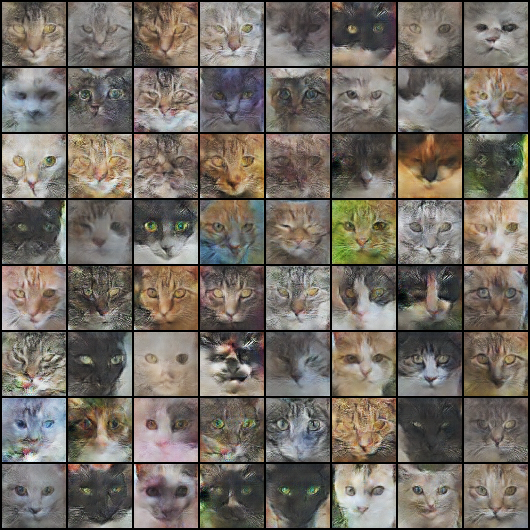

In [30]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')

In [31]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

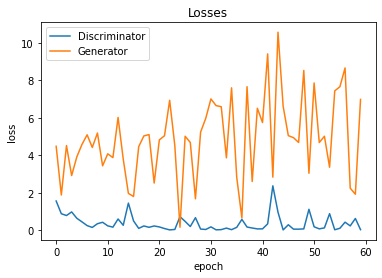

In [32]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

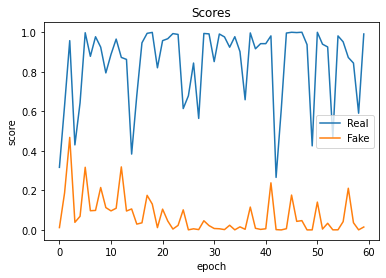

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');